### Libraries

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/AppliedDeepLearning')

In [3]:
import torch
import pandas as pd
# import torchvision
import numpy as np
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu
from tqdm.auto import tqdm
from loader import FlickrDataset,preprocessing_transforms,get_data_loader,denormalize,Padding
from vocab import Vocabulary
from csv import DictWriter
from model import EncoderCNN,DecoderRNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import time
import math
from torch.utils.data import DataLoader

In [4]:
import sys

In [5]:
# import sys
del sys.modules["loader"]
# del sys.modules['FlickrDataset']

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Building Vocabulary and Loading our data


In [7]:
vocab = Vocabulary(vocab_file = './drive/MyDrive/AppliedDeepLearning/vocab.txt')

In [8]:
vocab.load_vocab()

In [9]:
train_data = FlickrDataset('./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/train.csv', vocab = vocab,images_folder='./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/images', transform=preprocessing_transforms(),train_mode=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
val_data = FlickrDataset('./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/val.csv', vocab = vocab,images_folder='./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/images', transform=preprocessing_transforms(),train_mode = False)

In [12]:
train_loader= DataLoader(dataset=train_data, batch_size= 32,
                          num_workers=2,pin_memory=True, shuffle=True,  collate_fn= Padding(pad_idx=0,batch_first=True,train_mode = True))

val_loader = DataLoader(dataset=val_data, batch_size= 32,
                          num_workers=2,pin_memory=True, shuffle=True,  collate_fn= Padding(pad_idx=0,batch_first=True,train_mode = False))


In [12]:
i= 0
x, y,l,a = next(iter(val_loader))
for image, caption,length,all_caps in zip(x, y,l,a):
    image = denormalize(image)
    caption = [vocab.idx_to_word(int(word_id)) for word_id in caption]
    caption = ' '.join(word for word in caption)
    plt.imshow(image)
    plt.title(caption)
    print(length)
    print(all_caps)
    plt.show()
    plt.pause(1)
    i+=1
    if i ==1:
        break

KeyboardInterrupt: ignored

tensor(9)


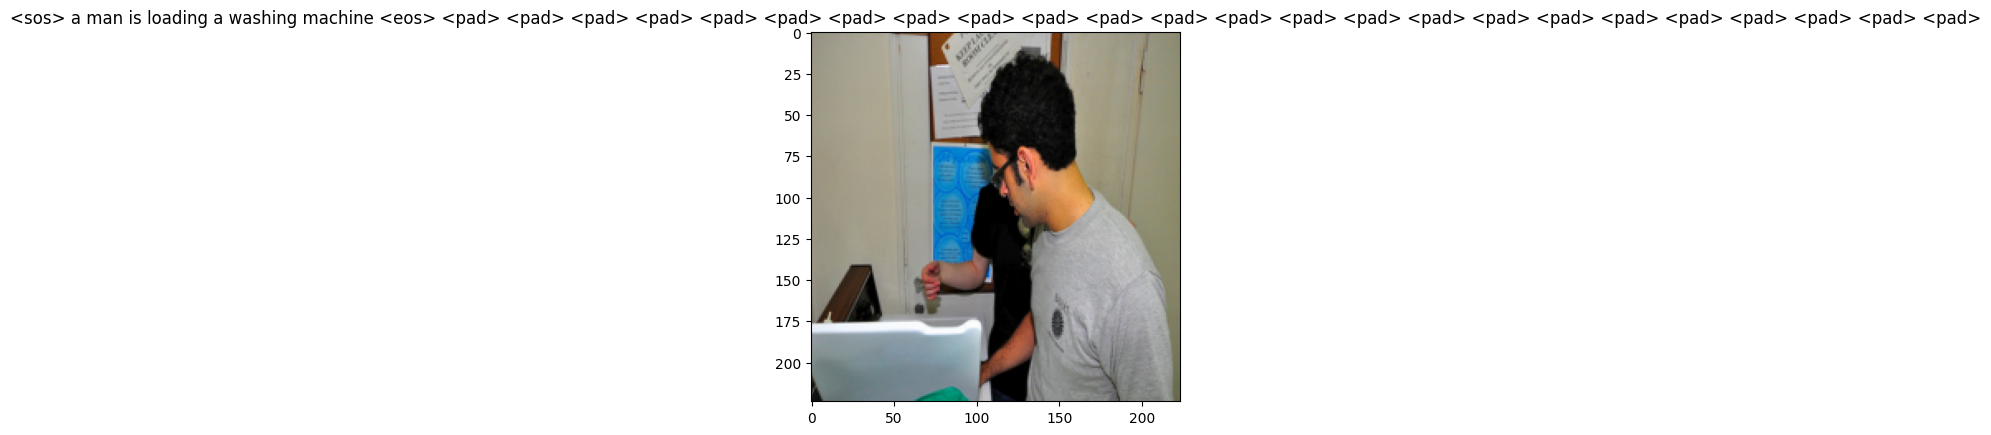

tensor(14)


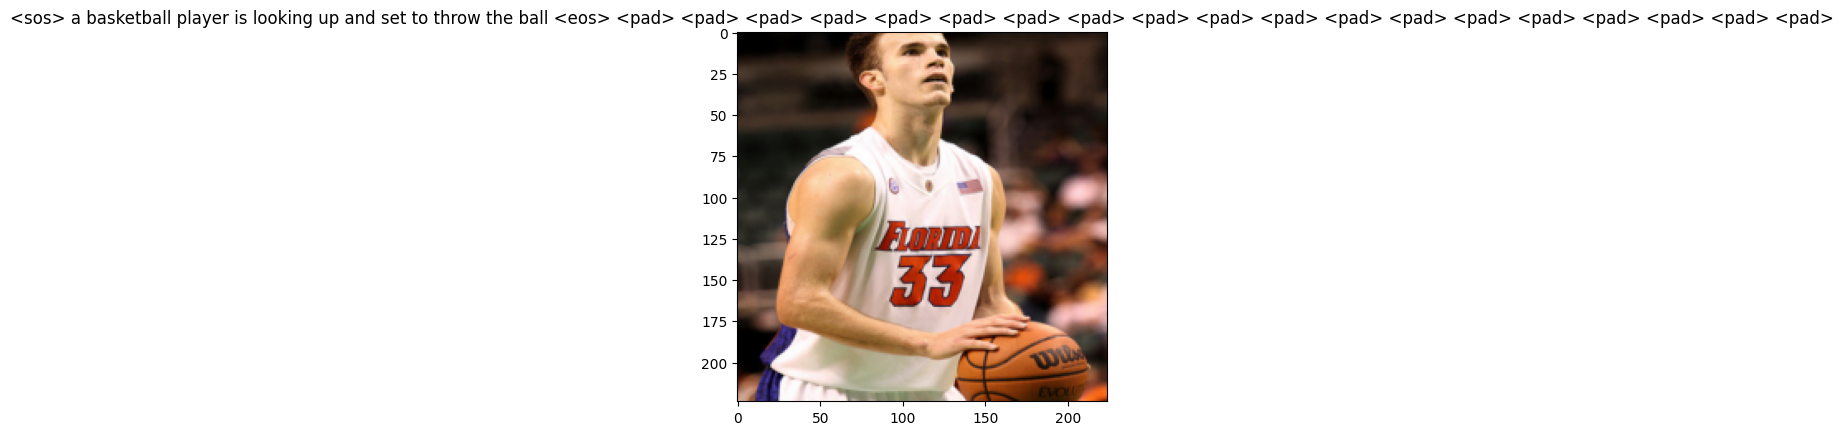

tensor(18)


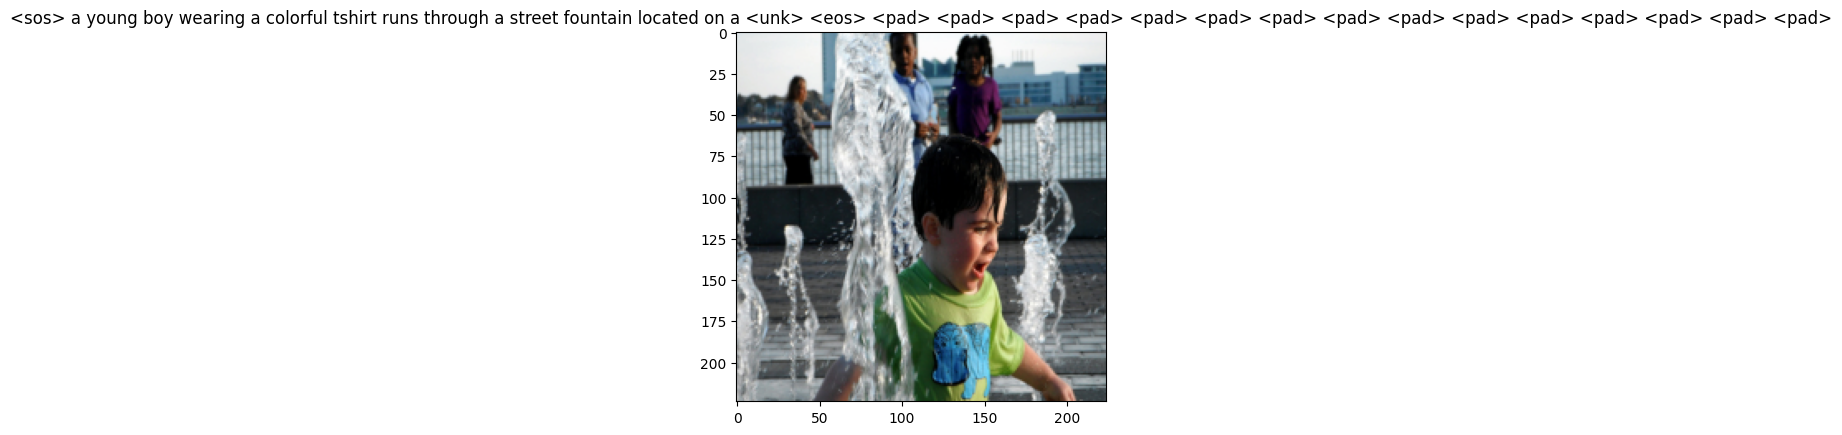

tensor(7)


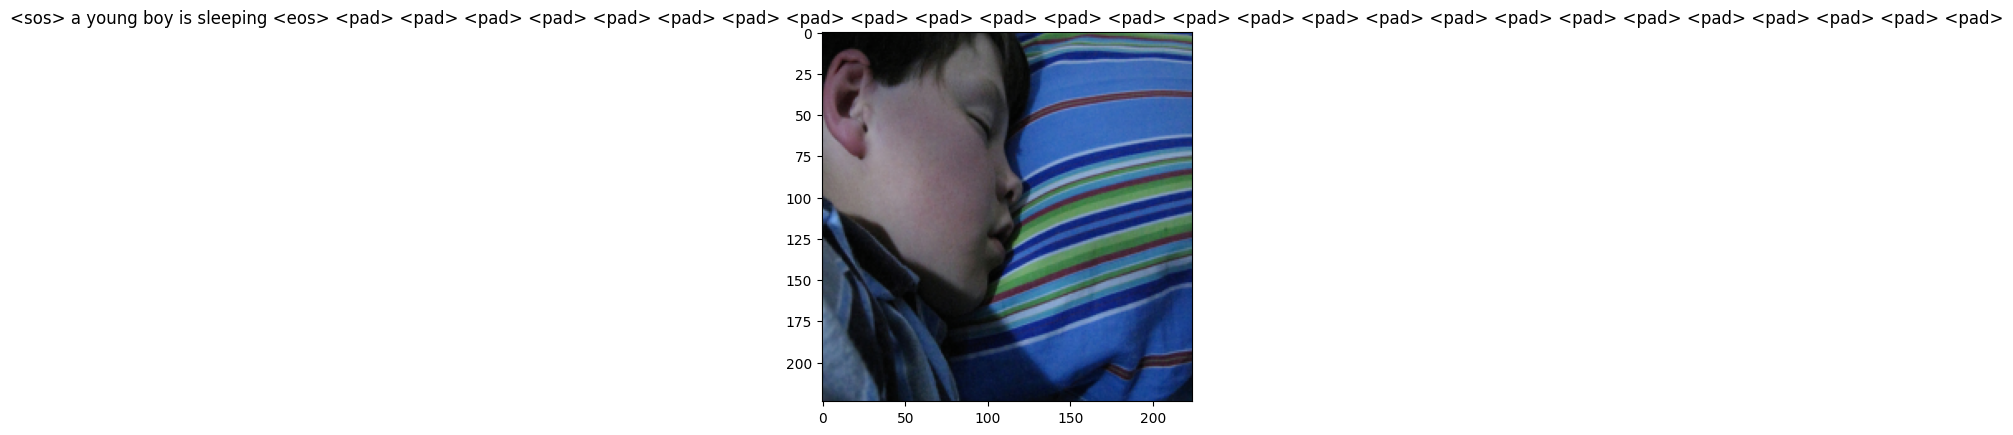

tensor(9)


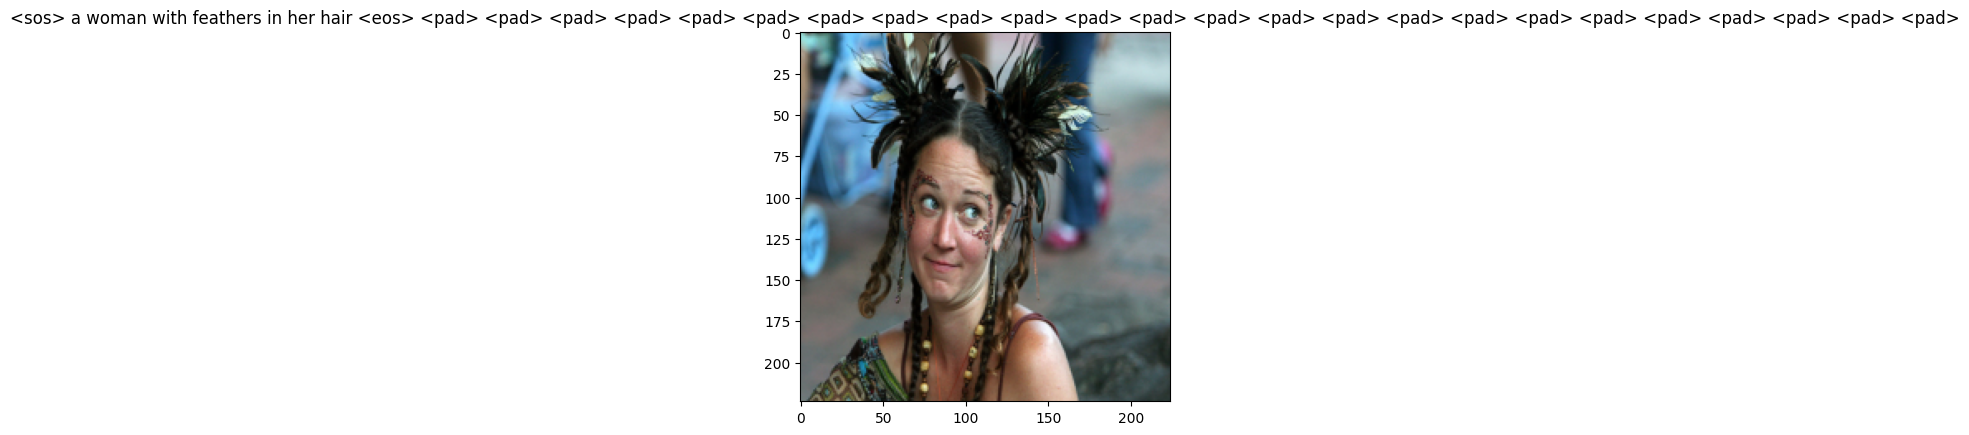

In [ ]:
i= 0
x, y,l = next(iter(train_loader))
for image, caption,length in zip(x, y,l):
    image = denormalize(image)
    caption = [vocab.idx_to_word(int(word_id)) for word_id in caption]
    caption = ' '.join(word for word in caption)
    plt.imshow(image)
    plt.title(caption)
    print(length)
    plt.show()
    plt.pause(1)
    i+=1
    if i ==1:
        break

### Model

In [13]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [14]:
def save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):

    state = {
        'epoch': epoch,
        'epochs_since_improvement': epochs_since_improvement,
        'bleu-4': bleu4,
        'encoder': encoder,
        'decoder': decoder,
        'encoder_optimizer': encoder_optimizer,
        'decoder_optimizer': decoder_optimizer
    }
    filename = 'image_captioning_checkpoint_' + str(epoch) + '.pth'
    torch.save(state, filename)
    if is_best:
        print('Saving the best model')
        torch.save(state, '/content/drive/MyDrive/AppliedDeepLearning/image_captioning_best.pth')

In [15]:
def train(train_loader,encoder, decoder, criterion, encoder_optimizer,decoder_optimizer):
    losses = []
    decoder.train()
    encoder.train()

    for i, (imgs,caps,cap_lens) in enumerate(tqdm(train_loader),len(train_loader)):
      imgs = imgs.to(device)
      caps = caps.to(device)
      cap_lens = cap_lens.to(device)

      imgs = encoder(imgs)
      scores, caps_sorted, decode_lengths, alphas =  decoder(imgs, caps, cap_lens)

      #from <start> to <end>
      targets = caps_sorted[:,1:]

      scores = pack_padded_sequence(scores, decode_lengths, batch_first=True,enforce_sorted=False).data
      targets = pack_padded_sequence(targets, decode_lengths, batch_first=True,enforce_sorted=False).data

      loss = criterion(scores,targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
      #backpropagation
      decoder_optimizer.zero_grad()
      if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
      loss.backward()

      if grad_clip is not None:
          clip_gradient(decoder_optimizer,grad_clip)
          if encoder_optimizer is not None:
            clip_gradient(encoder_optimizer,grad_clip)

      decoder_optimizer.step()
      if encoder_optimizer is not None:
            encoder_optimizer.step()
      losses.append(loss.item())

    return np.mean(losses)




In [16]:
def validate(val_loader,encoder, decoder, criterion):

    losses = []
    decoder.eval()
    encoder.eval()
    references = list()  # true captions
    hypotheses = list()  # predicted captions

    with torch.no_grad():
      for i, (imgs,caps,cap_lens,all_caps) in enumerate(tqdm(val_loader)):
          imgs = imgs.to(device)
          caps = caps.to(device)
          cap_lens = cap_lens.to(device)
          all_caps = all_caps
          imgs = encoder(imgs)

          scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, cap_lens)
          targets = caps_sorted[:, 1:]

          scores_copy = scores.clone()
          scores = pack_padded_sequence(scores, decode_lengths, batch_first=True,enforce_sorted=False).data
          targets = pack_padded_sequence(targets, decode_lengths, batch_first=True,enforce_sorted=False).data

          loss = criterion(scores, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

          losses.append(loss.item())
          for j in range(len(all_caps)):
            img_caps = all_caps[j].tolist()
            img_captions = list(map(lambda caption: [word for word in caption if word != 1 and word !=0],img_caps))
            references.append(img_captions)

          _, preds = torch.max(scores_copy, dim=2)
          preds = preds.tolist()
          temp_preds = list()
          for j, pred in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
          hypotheses.extend(temp_preds)


          assert len(references) == len(hypotheses)

          bleu1 = corpus_bleu(references, hypotheses, weights = (1.0, 0, 0, 0))
          bleu2 = corpus_bleu(references, hypotheses, weights = (0.5, 0.5, 0, 0))
          bleu3 = corpus_bleu(references, hypotheses, weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0))
          bleu4 = corpus_bleu(references, hypotheses)
    return np.mean(losses), bleu1,bleu2, bleu3, bleu4

In [ ]:
embed_dim = 512      # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512    # dimension of decoder RNN
encoder_dim = 2048
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
vocab_size = 5000
best_bleu4 = 0.
lr_decay_factor = 0.8
lr_decay_patience = 8
best_bleu4 = 0
patience = 6
file = '/content/drive/MyDrive/AppliedDeepLearning/model.csv'
num_epochs = 30
epochs_since_improvement = 0

fine_tune_encoder = False
checkpoint = './content/drive/MyDrive/AppliedDeepLearning/image_captioning_best.pth'
if checkpoint is None:
        decoder = DecoderRNN(attention_dim,embed_dim,decoder_dim, vocab_size, encoder_dim)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

        encoder = EncoderCNN()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None

else:
      checkpoint = torch.load('/content/drive/MyDrive/AppliedDeepLearning/image_captioning_best.pth')
      start_epoch = checkpoint['epoch'] + 1
      best_bleu4 = checkpoint['bleu-4']
      encoder = checkpoint['encoder']
      decoder = checkpoint['decoder']
      encoder_optimizer = checkpoint['encoder_optimizer']
      decoder_optimizer = checkpoint['decoder_optimizer']

encoder = encoder.to(device)
decoder = decoder.to(device)

encoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience) if fine_tune_encoder else None
decoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)
criterion = nn.CrossEntropyLoss().to(device)


for epoch in range(1,num_epochs+1):
  start = time.time()
  loss_train = train(train_loader,encoder,decoder,criterion, encoder_optimizer, decoder_optimizer)
  loss_val,bleu1_val, bleu2_val,bleu3_val,bleu4_val = validate(val_loader, encoder, decoder, criterion)

  decoder_lr_scheduler.step(bleu4_val)
  if fine_tune_encoder:
          encoder_lr_scheduler.step(bleu4_val)

  is_best = bleu4_val > best_bleu4
  if bleu4_val > best_bleu4:
    best_bleu4 = bleu4_val
    patience = 6

  else :
    patience -=1


  if patience <= 0:
    print('Triggering early stopping')
    break

  print('-' * 40)
  print(f'epoch: {epoch}, train loss: {loss_train:.4f}, valid loss: {loss_val:.4f},BLEU-1 {bleu1_val:.4f}, BLEU-2 {bleu2_val:.4f},BLEU-3 {bleu3_val:.4f} ,BLEU-4 {bleu4_val},best BLEU-4: {best_bleu4:.4f}')
  print(f'Time needed for epoch {epoch}', time.time()- start)
  print('-' * 40)
  d = {'epoch':epoch ,'train loss': loss_train, 'valid loss': loss_val,'bleu1': bleu1_val , 'bleu2': bleu2_val, 'bleu3': bleu3_val,'bleu4':bleu4_val,'best bleu4':best_bleu4 }

  with open(file,'a') as f:
        dictwriter_object = DictWriter(f, fieldnames=['epoch','train loss','valid loss','bleu1','bleu2','bleu3','bleu4','best bleu4'])
        dictwriter_object.writerow(d)
  save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, bleu4_val, is_best)



  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 1, train loss: 4.3412, valid loss: 4.4596,BLEU-1 0.5597, BLEU-2 0.3530,BLEU-3 0.2145 ,BLEU-4 0.13160100338861005,best BLEU-4: 0.1316
Time needed for epoch 1 2286.5331859588623
----------------------------------------
Saving the best model


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 2, train loss: 4.2903, valid loss: 4.4969,BLEU-1 0.5547, BLEU-2 0.3487,BLEU-3 0.2094 ,BLEU-4 0.12829066216923496,best BLEU-4: 0.1316
Time needed for epoch 2 2341.6618888378143
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 3, train loss: 4.2450, valid loss: 4.4847,BLEU-1 0.5553, BLEU-2 0.3473,BLEU-3 0.2083 ,BLEU-4 0.1266317112771085,best BLEU-4: 0.1316
Time needed for epoch 3 2241.8552465438843
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 4, train loss: 4.2015, valid loss: 4.4645,BLEU-1 0.5563, BLEU-2 0.3487,BLEU-3 0.2100 ,BLEU-4 0.12800774933266792,best BLEU-4: 0.1316
Time needed for epoch 4 2263.628092765808
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

----------------------------------------
epoch: 5, train loss: 4.1670, valid loss: 4.4709,BLEU-1 0.5585, BLEU-2 0.3521,BLEU-3 0.2135 ,BLEU-4 0.13078150833088098,best BLEU-4: 0.1316
Time needed for epoch 5 8130.451157331467
----------------------------------------


  0%|          | 0/4532 [00:00<?, ?it/s]

In [24]:
for j in range(all_caps):
  print(j)


NameError: ignored

In [ ]:
encoder = EncoderCNN().to(device)

In [ ]:
decoder = DecoderRNN(num_features=1048,embedding_dim = 256, hidden_dim =512,vocab_size =  5000,).to(device)


In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)
parameters = list(decoder.parameters())

In [ ]:
optimizer = torch.optim.Adam(params=parameters, lr= 0.0001)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
log_train = 'training_log.txt'
log_val = 'validation_log.txt'
bleu = 'bleu.txt'

### Training my model

In [ ]:
train_steps = math.ceil(len(train_loader.dataset)/train_loader.batch_sampler.batch_size)
print_every = 100

NameError: name 'encoder' is not defined

In [ ]:
def train(epoch, encoder,decoder,optimizer,criterion,num_epochs,data_loader,write_file,total_step,save_every = 1,vocab_size = 5000):
    epoch_loss = 0
    epoch_perplex = 0
    for i in range(1,total_step+1):
        encoder.eval()
        decoder.train()
        images,captions = next(iter(data_loader))

        captions_target =captions[:,1:].to(device)
        captions_train = captions[:,1:].to(device)

        images = images.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        features = encoder(images)
        outputs,atten_weights = decoder(captions_train,features)

        #batch loss
        loss = criterion(outputs.view(-1,vocab_size),captions_target.reshape(-1))
        loss.backward()
        optimizer.step()

        perplex = np.exp(loss.item())
        epoch_loss += loss.item()
        epoch_perplex += perplex
        stats = 'Epoch train: [%d/%d], Step train: [%d/%d], Loss train: %.4f, Perplexity train: %5.4f' % (epoch, num_epochs, i, total_step, loss.item(), perplex)
        print('\r' + stats, end="")
        sys.stdout.flush()

        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()

        # Print training statistics (on different line).
        if i % print_every == 0:
            print('\r' + stats)

    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex /total_step
    print('\r')
    print('Epoch train:', epoch)
    print('\r' + 'Avg. Loss train: %.4f, Avg. Perplexity train: %5.4f' % (epoch_loss_avg, epoch_perp_avg), end="")
    print('\r')






In [ ]:
def validate(epoch, encoder, decoder, optimizer,criterion, total_step,num_epochs,data_loader, write_file, bleu_score_file,vocab_size = 5000 ):

    epoch_loss = 0
    epoch_perplex = 0
    references = []
    hypothesis = []

    for i in range(1, total_step+1):
        encoder.eval()
        decoder.eval()
        val_images, val_captions  = next(iter(data_loader))

        val_captions_target = val_captions[:,1:].to(device)
        val_captions = val_captions[:,:-1].to(device)
        val_images = val_images.to(device)

        features_val = encoder(val_images)
        outputs_val, atten_weights_val = decoder(captions = val_caption,features = features_val)
        loss_val = criterion(outputs_val.view(-1, vocab_size),
                             val_captions_target.reshape(-1))
        references.append(captions)


4532

In [ ]:
len(val_data)

5070

32

In [ ]:
total_steps

4532

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence


In [ ]:
encoder_model =

In [ ]:
best_bleu4 = -100
no_improvement = 0
patience = 3
early_stopper = False
for epoch in range(3):
    train_loss = []
    val_loss = []
    predictions = []
    references = []

    for images,captions,lengths in tqdm(train_loader):
        encoder.train()
        decoder.train()
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]

        #forward, backward and optimization
        features = encoder(images)
        outputs = decoder(features,captions,lengths)
        t_loss = criterion(outputs,targets)

        t_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(t_loss.item())


    with torch.no_grad():
        for images,captions,lengths in tqdm(val_loader):
            encoder.eval()
            decoder.eval()

            images = images.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            features = encoder(image)
            targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]
            decoder(features,captions,lengths)
            v_loss = criterion(outputs,targets)

            hypotheses_ids = decoder.sample(features)
            hypotheses_ids = hypotheses_ids[0].cpu().numpy()


            # Convert word_ids to words
            sampled_caption = []
            for word_id in hypotheses_ids:
                word = vocab.idx_to_word[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)

            val_loss.append(v_loss)
            predictions.append(predictions)
            references.append(targets)

    bleu4 = corpus_bleu(references, predictions)
    print(f'Epoch {epoch +1} Train Loss : {np.mean(train_loss)} ')
    print(f'Epoch {epoch +1} Validation Loss : {np.mean(val_loss)} , BLEU Score {bleu4} ')

    if bleu4 > best_bleu4:
        torch.save(encoder.state_dict(), encoder_model)
        torch.save(decoder.state_dict(),decoder_model)
        best_bleu4 = bleu4
        no_improvement = 0
    else:
        no_improvement +=1

    if no_improvement >= patience:
        early_stopper = True
        print(f'Triggering early stopping at epoch {epoch+1}')
        break


Exception ignored in: <function tqdm.__del__ at 0x7f853ebd17e0>
Traceback (most recent call last):
  File "/Users/nadia/opt/anaconda3/envs/adlproject/lib/python3.10/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/Users/nadia/opt/anaconda3/envs/adlproject/lib/python3.10/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


  0%|          | 0/4532 [01:29<?, ?it/s]

ValueError: Expected input batch_size (24) to match target batch_size (429).